In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import ollama

# Load dataset
df = pd.read_csv("survey.csv")
df = df.dropna()



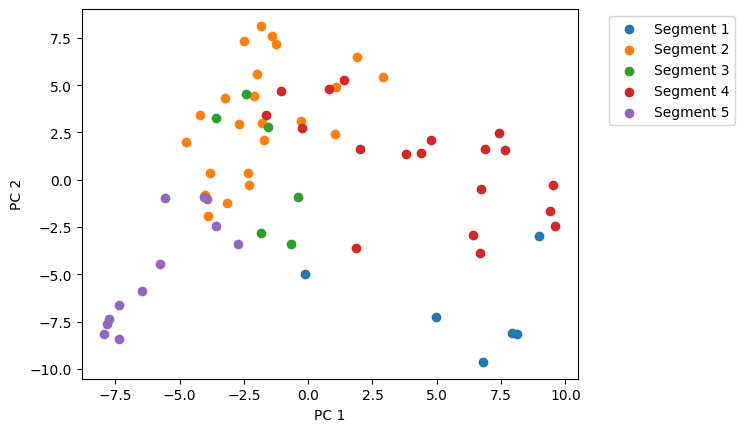

In [9]:
# Define the embedding model
embedding_model = "mxbai-embed-large"

# Function to get embeddings from Ollama
def get_embedding(text):
    return ollama.embeddings(model=embedding_model, prompt=text)["embedding"]

# Generate embeddings for job titles and join reasons
job_embeddings = df['job_title'].apply(get_embedding)
reason_embeddings = df['join_reason'].apply(get_embedding)

# Combine embeddings into a single vector
embedding_list = [job_embeddings.iloc[i] + reason_embeddings.iloc[i] for i in range(len(df))]

# Convert to DataFrame
df_embeddings = pd.DataFrame(embedding_list)

# Clustering with KMeans
num_segments = 5
clustering = KMeans(n_clusters=num_segments, random_state=0).fit(df_embeddings)

# Add segments to the survey data
df["segment"] = clustering.labels_ + 1

# PCA for visualization
X = PCA(n_components=2).fit_transform(df_embeddings)

# Plot each segment
for label in range(num_segments):
    indexes = np.where(clustering.labels_ == label)[0]
    plt.scatter(X[indexes, 0], X[indexes, 1], label=f"Segment {label+1}")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()




In [10]:
# Function to convert DataFrame to Markdown
def dataframe_to_markdown(df):
    markdown = f"| {' | '.join(df.columns)} |\n"
    markdown += f"| {' | '.join(['-' * len(col) for col in df.columns])} |\n"
    for _, row in df.iterrows():
        markdown += f"| {' | '.join(str(cell) for cell in row)} |\n"
    return markdown

# Prompt template for customer segmentation
def prompt_template(markdown_table):
    return f"""You are a business strategist specializing in customer segmentation and profiling. \
Below is a table of survey responses from customers, including their job titles and reasons for joining an AI bootcamp. \
Your task is to analyze the responses and generate a **single predominant customer profile** that represents the most common \
characteristics and motivations across the group.

Please include:
1. **Job Title**: A single representative job title summarizing those listed in the table
2. **Desired Outcomes**: A single representative desired outcome synthesizing those listed in the table
3. **Key Challenges**: A single representative key challenge synthesizing those listed in the table

### Survey Responses

{markdown_table}

### Instructions:
- Keep each section concise (1 sentence or bullet points).
- Use simple language and avoid unnecessary details.
- Total response should be under **100 words**.
- Only include the three items listed above (i.e. Job Title, Desired Outcomes, and Key Challenges).

Begin your analysis and generate the customer profile below:
"""



In [11]:
# Function to generate customer avatar using Ollama LLM
def generate_avatar(df_segment):
    markdown_table = dataframe_to_markdown(df_segment)
    prompt = prompt_template(markdown_table)
    
    # Generate response using Ollama (GPT-4 alternative)
    # response = ollama.chat(model="llama3.2:latest", messages=[{"role": "user", "content": prompt}])
    response = ollama.chat(model="deepseek-r1:8b", messages=[{"role": "user", "content": prompt}])

    
    return response["message"]["content"]

# Generate avatars for each segment
for i in range(num_segments):
    survey_data = df[clustering.labels_ == i][['job_title', 'join_reason']]
    print("Segment", i + 1, "| Size:", len(survey_data))
    print(generate_avatar(survey_data))
    print("-" * 100)

# Filter a specific segment
df[df["segment"] == 5]

Segment 1 | Size: 6
<think>
Alright, so I need to analyze the survey responses provided and create a single predominant customer profile that represents the most common characteristics and motivations across the group. The task requires me to summarize three main components: Job Title, Desired Outcomes, and Key Challenges.

First, looking at the job titles in the table: there are several "Founders" and one "Learner." Given that there's only one Learner, it might seem like Founders are the predominant group. However, I should consider whether the Learner's role is similar enough to the Founders to be included in the summary or if a separate profile is needed. The instructions mention creating a single predominant customer profile, so maybe Founders would represent the primary target.

Next, examining the reasons for joining an AI bootcamp: most of them are related to building and refining LLMs, understanding AI concepts like RAG (Retrieval-Augmented Generation), and wanting to apply the

,job_title,join_reason,segment
3,Staff Scientist,Better understanding and skill set in AI to ma...,5
4,Data scientist,Getting skills (for my resume),5
10,ML Engineer,- Technical skills: learn to use LLMs/ AI\n- S...,5
14,Data Scientist,Gain hands-on experience interfacing with LLMs...,5
16,Head of Data Solutions,I am on a journey to become a Citizen Data Sci...,5
36,Data Scientist,Bridge any knowledge gaps and improve my under...,5
44,Technology Analyst,Become more familliar with Python from a data ...,5
61,Data scientist,Upgrading my skills in data science (to find a...,5
63,Data Scientist,I would like to be more participative in the c...,5
65,ML Engineer,- Review material and gain a deeper understand...,5


In [12]:
df[df["segment"] == 1]

,job_title,join_reason,segment
0,Founder,"How to fine tune LLM effectively, and what LLM...",1
8,Founder,I want to build A.I. agents to make my job eas...,1
17,Learner,Learn basics and want to know what all fits wh...,1
43,Founder,Learn about LLM and RAG,1
58,Founder,I would like to able to replicate by myself so...,1
59,Co-founder,Revise and build upon from previous cohort.,1


In [13]:
df[df["segment"] == 3]

,job_title,join_reason,segment
5,Solutions Architect,"I would like to understand AI, how to create L...",3
12,Senior Specialist,Experience setting up my own environment and h...,3
30,Senior Developer,Learn to create my own LLM,3
32,Information security lead,Learn how to train and apply llm in real use c...,3
47,Senior Software Engineer,Hands on experience in learning AI that will h...,3
80,Senior software developer,Developer-level understanding of Gen-AI and re...,3


In [14]:
df[df["segment"] == 5]

,job_title,join_reason,segment
3,Staff Scientist,Better understanding and skill set in AI to ma...,5
4,Data scientist,Getting skills (for my resume),5
10,ML Engineer,- Technical skills: learn to use LLMs/ AI\n- S...,5
14,Data Scientist,Gain hands-on experience interfacing with LLMs...,5
16,Head of Data Solutions,I am on a journey to become a Citizen Data Sci...,5
36,Data Scientist,Bridge any knowledge gaps and improve my under...,5
44,Technology Analyst,Become more familliar with Python from a data ...,5
61,Data scientist,Upgrading my skills in data science (to find a...,5
63,Data Scientist,I would like to be more participative in the c...,5
65,ML Engineer,- Review material and gain a deeper understand...,5
